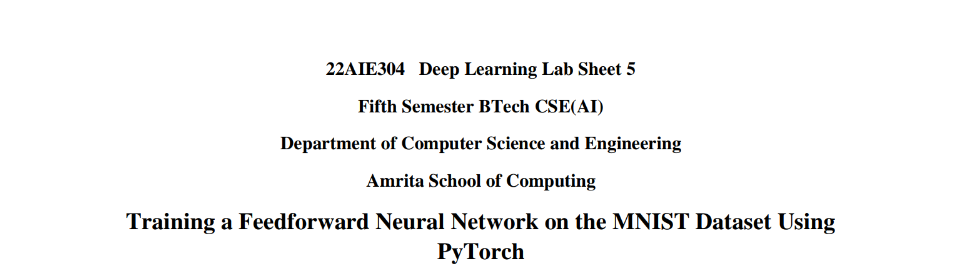

# **ANUVIND M P**
# **AM.EN.U4AIE22010**

# **1**
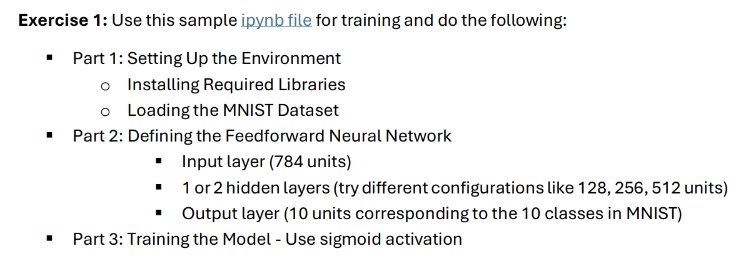

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size=784, output_size=10, hidden_sizes=[128], activation_fn=nn.ReLU):
        super(FeedForwardNN, self).__init__()
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(activation_fn())
            input_size = hidden_size
        layers.append(nn.Linear(input_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, device):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.view(inputs.size(0), -1).to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(epoch_train_loss / total)
        train_acc.append(correct / total)

        model.eval()
        epoch_val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.view(inputs.size(0), -1).to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(epoch_val_loss / total)
        val_acc.append(correct / total)

    return train_loss, val_loss, train_acc, val_acc

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_subset, val_subset = random_split(train_set, [train_size, val_size])

HLayers = [1, 2]
hidden_sizes = [64, 128, 256, 512]
activations = [nn.ReLU, nn.Sigmoid, nn.Tanh, nn.LeakyReLU]
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [16, 32, 64, 128]
optimizers = {"SGD": optim.SGD, "Adam": optim.Adam, "RMSprop": optim.RMSprop}
epochs = 10

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 22.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 627kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.60MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.72MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
confusion_matrices = []

def compute_confusion_matrix(model, data_loader, device):
    """Compute confusion matrix for the given model and data_loader."""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.view(inputs.size(0), -1).to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return confusion_matrix(all_labels, all_preds)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_subset, val_subset = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# **2**
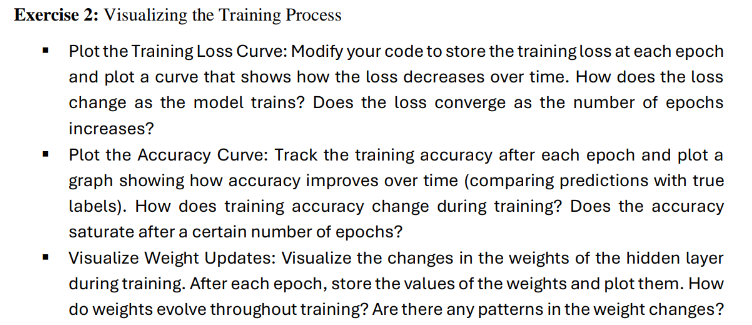

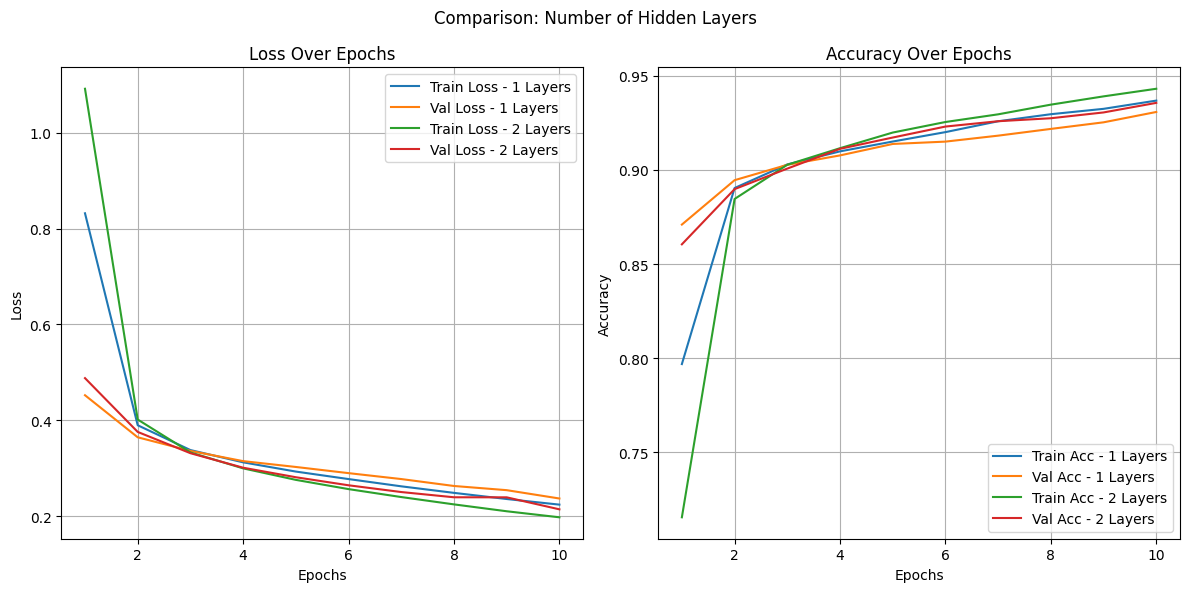

In [ ]:
results = []
for hidden_layers in HLayers:
    model = FeedForwardNN(
        hidden_sizes=[128] * hidden_layers,
        activation_fn=nn.ReLU
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, epochs, criterion, optimizer, device
    )
    results.append((train_loss, val_loss, train_acc, val_acc))

    cm = compute_confusion_matrix(model, val_loader, device)
    confusion_matrices.append({
        "experiment": f"{hidden_layers} Hidden Layers",
        "confusion_matrix": cm
    })

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, hidden_layers in enumerate(HLayers):
    axs[0].plot(range(1, epochs + 1), results[i][0], label=f"Train Loss - {hidden_layers} Layers")
    axs[0].plot(range(1, epochs + 1), results[i][1], label=f"Val Loss - {hidden_layers} Layers")
    axs[1].plot(range(1, epochs + 1), results[i][2], label=f"Train Acc - {hidden_layers} Layers")
    axs[1].plot(range(1, epochs + 1), results[i][3], label=f"Val Acc - {hidden_layers} Layers")

axs[0].set_title("Loss Over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Accuracy Over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.suptitle("Comparison: Number of Hidden Layers")
plt.tight_layout()
plt.show()


#**3**
 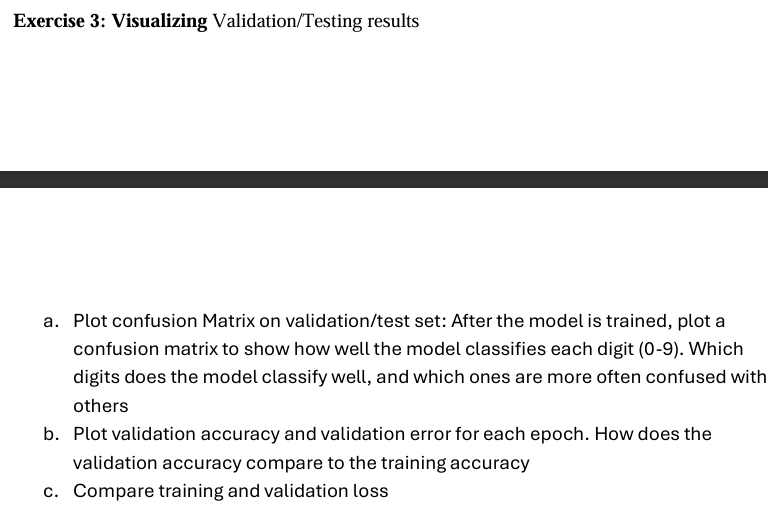

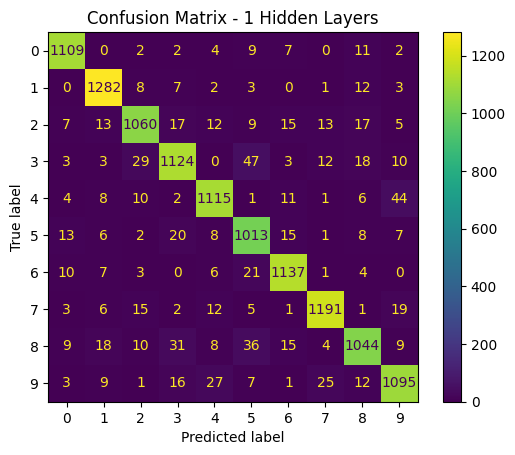

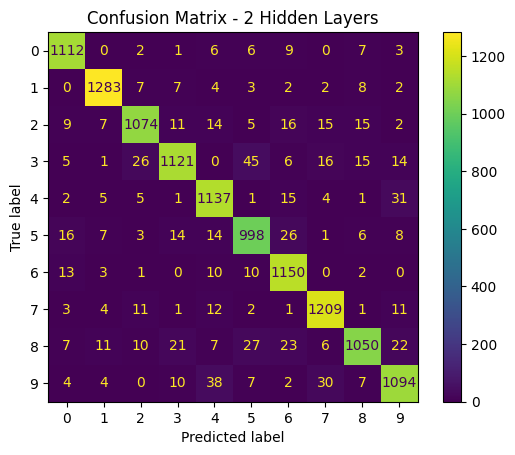

In [ ]:
for entry in confusion_matrices:
    experiment_name = entry["experiment"]
    cm = entry["confusion_matrix"]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(cm.shape[0]))
    disp.plot(cmap="viridis")
    plt.title(f"Confusion Matrix - {experiment_name}")
    plt.show()

# **4**
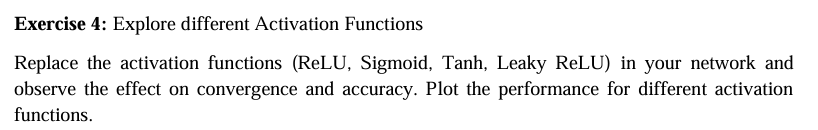

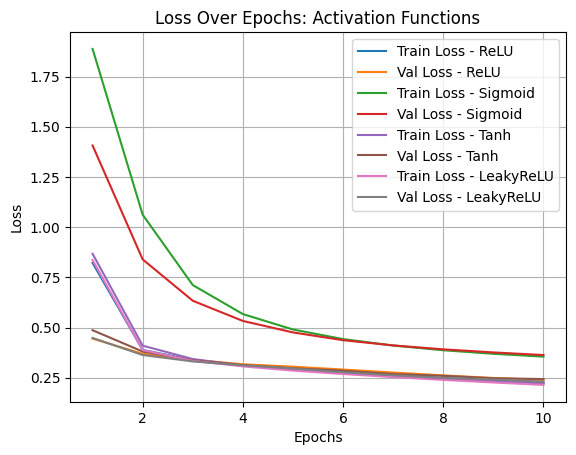

In [ ]:
for activation_fn in activations:
    model = FeedForwardNN(
        hidden_sizes=[128],
        activation_fn=activation_fn
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, epochs, criterion, optimizer, device
    )

    # Plot results
    plt.plot(range(1, epochs + 1), train_loss, label=f"Train Loss - {activation_fn.__name__}")
    plt.plot(range(1, epochs + 1), val_loss, label=f"Val Loss - {activation_fn.__name__}")

plt.title("Loss Over Epochs: Activation Functions")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# **5**
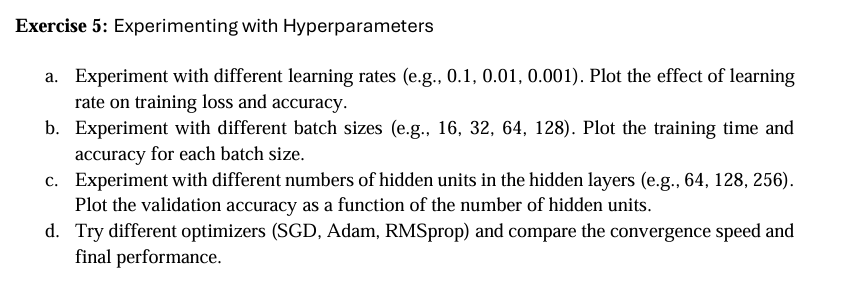

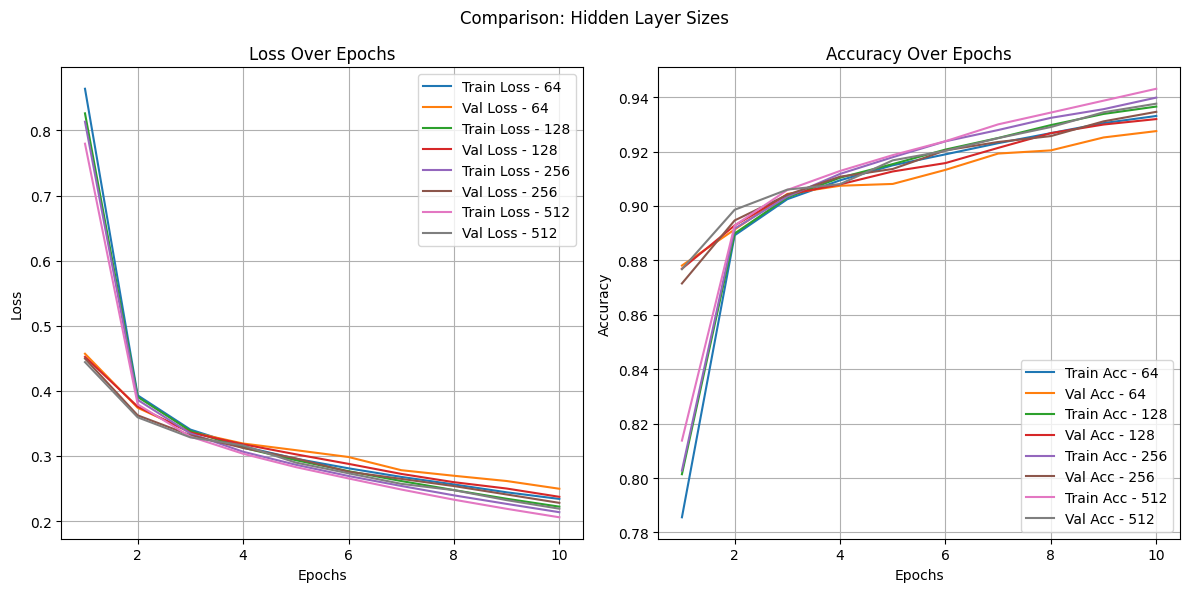

In [ ]:
results = []
for hidden_size in hidden_sizes:
    model = FeedForwardNN(
        hidden_sizes=[hidden_size] * 1,
        activation_fn=nn.ReLU
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, epochs, criterion, optimizer, device
    )
    results.append((train_loss, val_loss, train_acc, val_acc))

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, hidden_size in enumerate(hidden_sizes):
    axs[0].plot(range(1, epochs + 1), results[i][0], label=f"Train Loss - {hidden_size}")
    axs[0].plot(range(1, epochs + 1), results[i][1], label=f"Val Loss - {hidden_size}")
    axs[1].plot(range(1, epochs + 1), results[i][2], label=f"Train Acc - {hidden_size}")
    axs[1].plot(range(1, epochs + 1), results[i][3], label=f"Val Acc - {hidden_size}")

axs[0].set_title("Loss Over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Accuracy Over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.suptitle("Comparison: Hidden Layer Sizes")
plt.tight_layout()
plt.show()


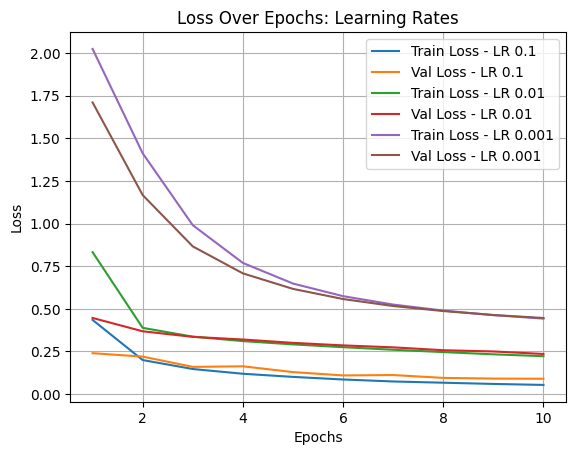

In [ ]:
for lr in learning_rates:
    model = FeedForwardNN(
        hidden_sizes=[128],
        activation_fn=nn.ReLU
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, epochs, criterion, optimizer, device
    )

    # Plot results
    plt.plot(range(1, epochs + 1), train_loss, label=f"Train Loss - LR {lr}")
    plt.plot(range(1, epochs + 1), val_loss, label=f"Val Loss - LR {lr}")

plt.title("Loss Over Epochs: Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


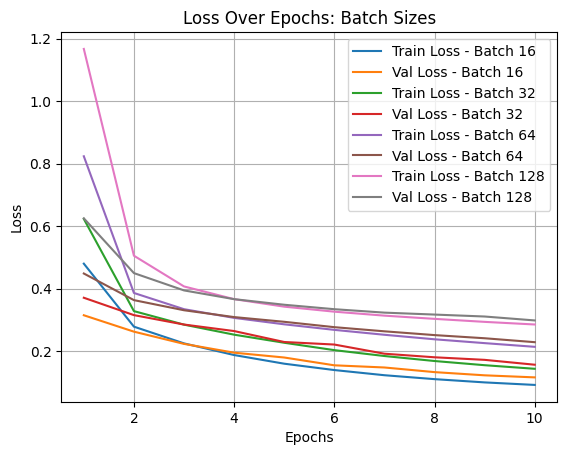

In [ ]:
for batch_size in batch_sizes:
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = FeedForwardNN(
        hidden_sizes=[128],
        activation_fn=nn.ReLU
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, epochs, criterion, optimizer, device
    )

    # Plot results
    plt.plot(range(1, epochs + 1), train_loss, label=f"Train Loss - Batch {batch_size}")
    plt.plot(range(1, epochs + 1), val_loss, label=f"Val Loss - Batch {batch_size}")

plt.title("Loss Over Epochs: Batch Sizes")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

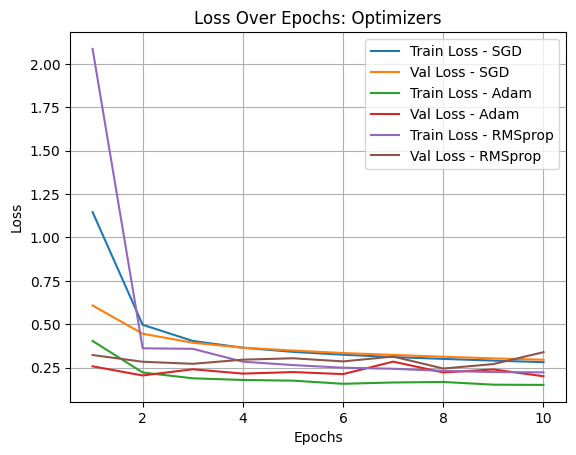

In [ ]:
for name, optimizer_fn in optimizers.items():
    model = FeedForwardNN(
        hidden_sizes=[128],
        activation_fn=nn.ReLU
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_fn(model.parameters(), lr=0.01)

    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, epochs, criterion, optimizer, device
    )

    # Plot results
    plt.plot(range(1, epochs + 1), train_loss, label=f"Train Loss - {name}")
    plt.plot(range(1, epochs + 1), val_loss, label=f"Val Loss - {name}")

plt.title("Loss Over Epochs: Optimizers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd

performance_data = []

for idx, (train_loss, val_loss, train_acc, val_acc) in enumerate(results):
    performance_data.append({
        "Experiment": f"Experiment {idx + 1}",
        "Train Loss": train_loss[-1],
        "Validation Loss": val_loss[-1],
        "Train Accuracy (%)": train_acc[-1] * 100,
        "Validation Accuracy (%)": val_acc[-1] * 100
    })

performance_df = pd.DataFrame(performance_data)
print("Model Performance Summary")
print(performance_df)

Model Performance Summary
     Experiment  Train Loss  Validation Loss  Train Accuracy (%)  \
0  Experiment 1    0.228985         0.229270           93.481250   
1  Experiment 2    0.220583         0.223019           93.764583   
2  Experiment 3    0.216583         0.217687           93.879167   
3  Experiment 4    0.208605         0.208130           94.150000   

   Validation Accuracy (%)  
0                93.433333  
1                93.483333  
2                93.850000  
3                94.166667  
